In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import pathlib
import time
%matplotlib inline

In [2]:
# turn response caching on and turn on logging to your terminal window
ox.config(log_console=True, use_cache=True)

ox.__version__

'1.0.0'

In [15]:
places = [{'county' : 'Merida',
           'state' : 'Yucatan',
           'country' : 'Mexico'},
          {'county' : 'Kanasin',
           'state' : 'Yucatan',
           'country' : 'Mexico'}]

def get_roads_osmnx(places, update=False, proj=False, crs=None):

    dirpath = pathlib.Path('./networks/')
    filepath = dirpath/'merida-kanasin-road.graphml'
    logpath = dirpath/'log'
                                    
    if filepath.exists() and not update:
        G = ox.load_graphml(filepath)
    else:
        # get drivable public streets network, aka road network, without service roads,
        # e.g. private, parking lots, etc.
        # use retain_all if you want to keep all disconnected subgraphs (e.g. when your places aren't adjacent)
        # TODO: It would be nice to setup up a polygon for the city and its surrounding areas, to be sure
        # exactly the location.
        G = ox.graph_from_place(places, network_type='drive')
        ox.save_graphml(G, filepath=filepath, gephi=False)
        
    if proj:
        G = ox.project_graph(G, to_crs=crs)
    
    print(f"Graph created at: {G.graph['created_date']}")
    return G, *ox.graph_to_gdfs(G)
        
#G, nodes, edges = get_roads_osmnx(places, update=False)
G_proj, nodes_proj, edges_proj = get_roads_osmnx(places, update=False, proj=True, crs=3857)

Graph created at: 2021-02-17 11:57:58


In [16]:
# get largest strongly connected component
Gs = ox.utils_graph.get_largest_component(G_proj, strongly=True)

In [197]:
print(f"The largest component has {Gs.number_of_edges()} edges and {Gs.number_of_nodes()} nodes")

The largest component has 102131 edges and 37746 nodes


In [3]:
# read road network stats of the city
stats_city = pd.read_csv('stats_road_network.csv', encoding='utf-8')

## Visualizing Betweenness centrality

In [134]:
btwn_scores = ast.literal_eval(stats_city['betweenness_centrality'].iloc[0])

In [135]:
max_node, max_bc = max(btwn_scores.items(), key=lambda x: x[1])

In [136]:
max_node, max_bc

(8229079034, 0.06618414910391013)

In the city of Mérida, Yucatán, the node with the highest betwenness centrality has ~7% of all shortest paths running through it. Let's highlight it in the plot:

In [137]:
nc = ['r' if node==max_node else 'w' for node in Gs.nodes()]
ns = [80 if node==max_node else 0 for node in Gs.nodes()]

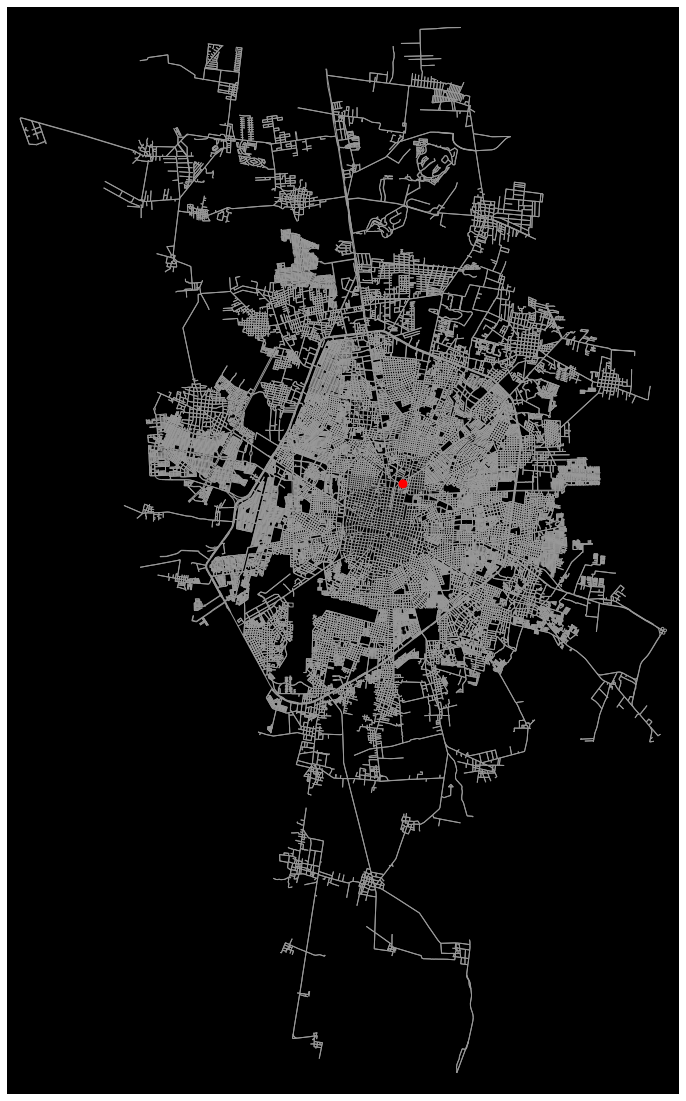

In [138]:
fig, ax = ox.plot_graph(Gs, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20))

A closer look:

In [139]:
# create a network around some (lat, lng) point and plot it
location_point = (20.9774, -89.6169)
G_closer = ox.graph_from_point(location_point, dist=10000, simplify=True, network_type='drive')
G_closer_proj = ox.project_graph(G_closer, to_crs=3857)

In [140]:
nc = ['r' if node==max_node else 'w' for node in G_closer_proj.nodes()]
ns = [80 if node==max_node else 0 for node in G_closer_proj.nodes()]

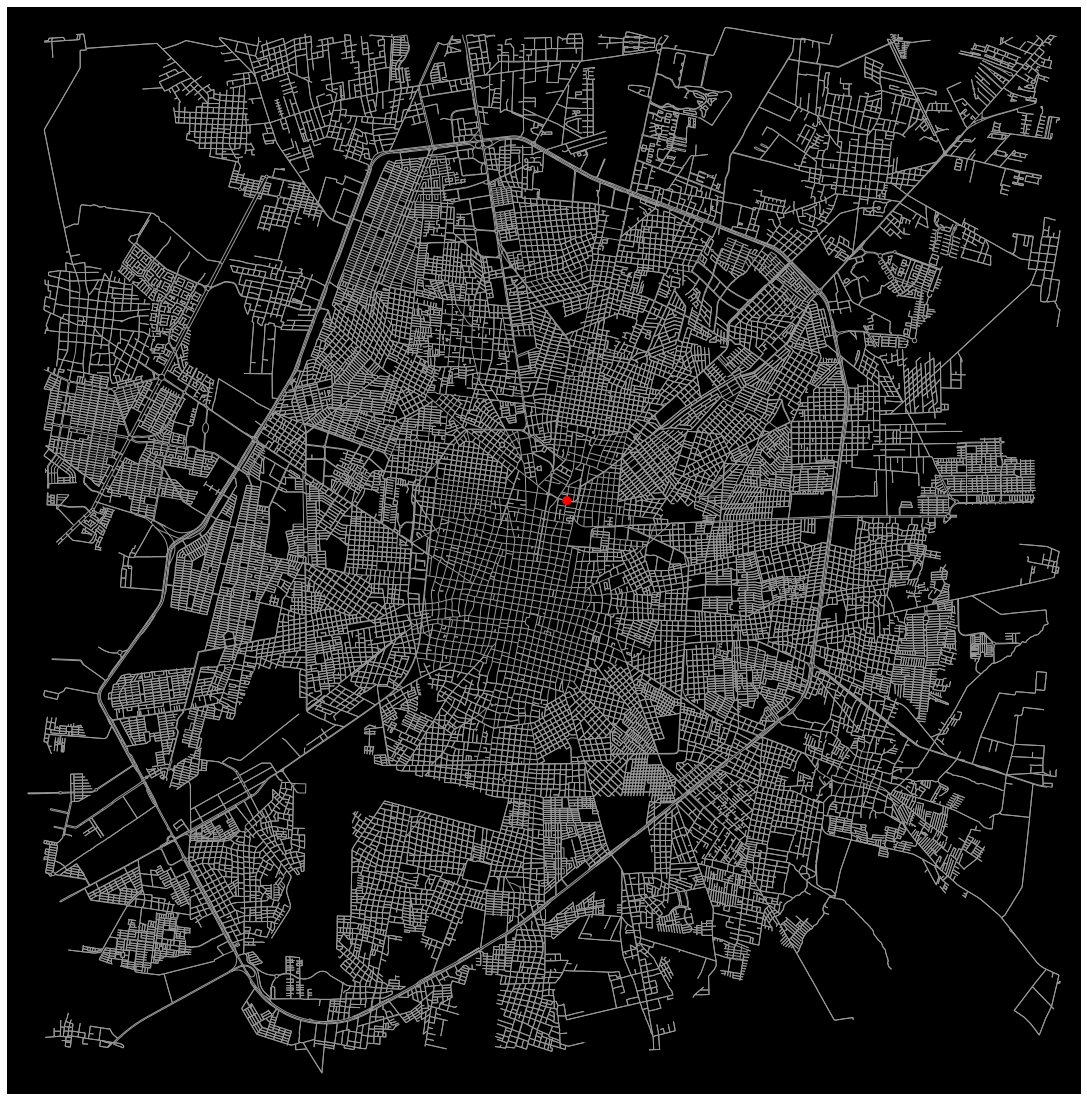

In [141]:
fig, ax = ox.plot_graph(G_closer_proj, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20)
                       )

A more closer look:

In [142]:
# create a network around some (lat, lng) point and plot it
location_point = (20.98476, -89.61411)
G_closerer = ox.graph_from_point(location_point, dist=1000, network_type='drive')
G_closerer_proj = ox.project_graph(G_closerer, to_crs=3857)

In [143]:
nc = ['r' if node==max_node else 'w' for node in G_closerer_proj.nodes()]
ns = [80 if node==max_node else 0 for node in G_closerer_proj.nodes()]

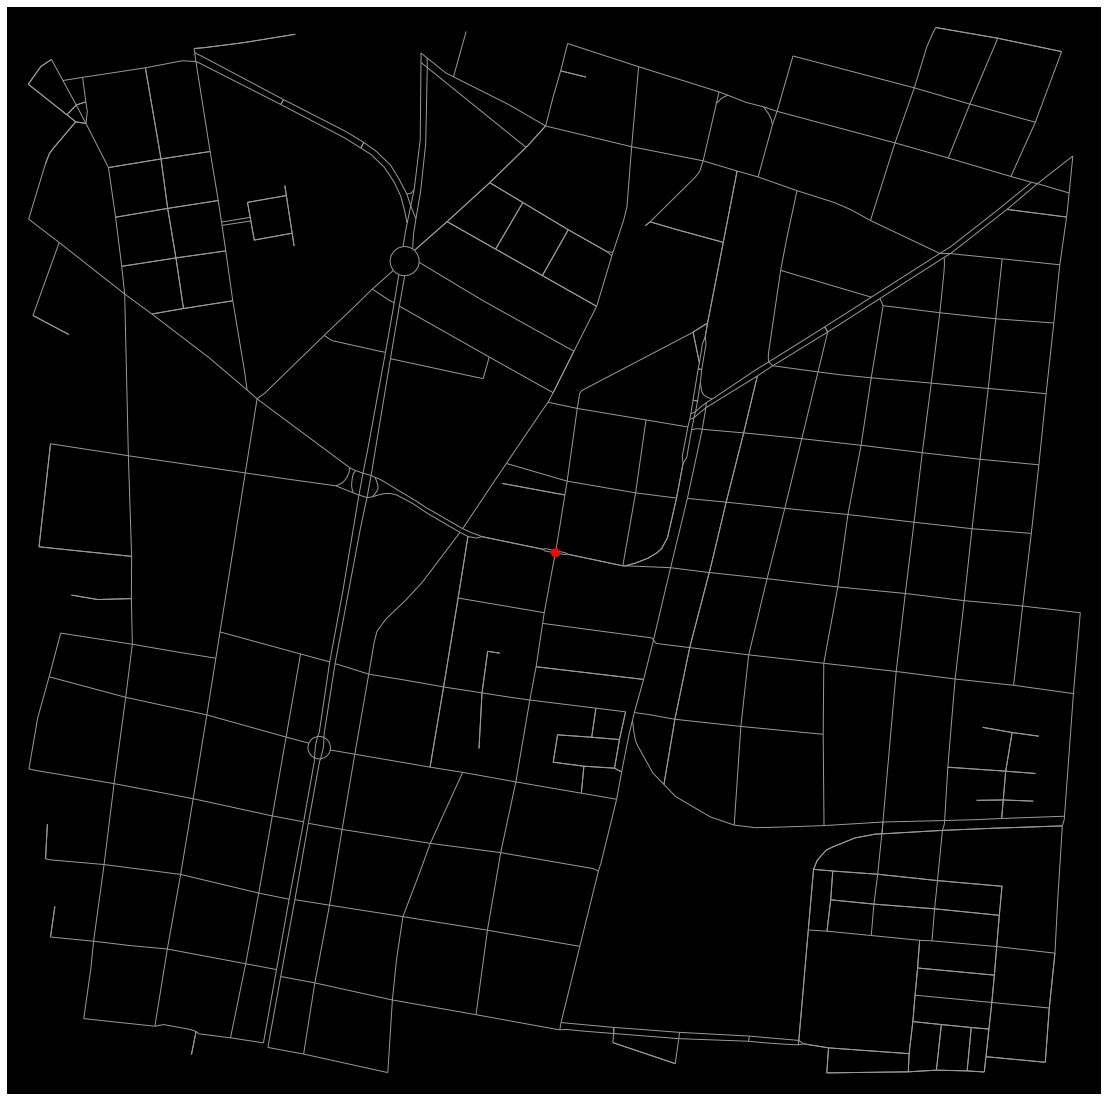

In [144]:
fig, ax = ox.plot_graph(G_closerer_proj, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20)
                       )

This node is the intersection at 52 street and Perez Ponce Avenue. View in OpenStreetMap: https://www.openstreetmap.org/search?whereami=1&query=20.98476%2C-89.61411#map=19/20.98477/-89.61409

~7% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

In [ ]:
nx.set_node_attributes(Gs, btwn_scores, 'bc')
nc = ox.plot.get_node_colors_by_attr(Gs, 'bc', cmap='plasma')

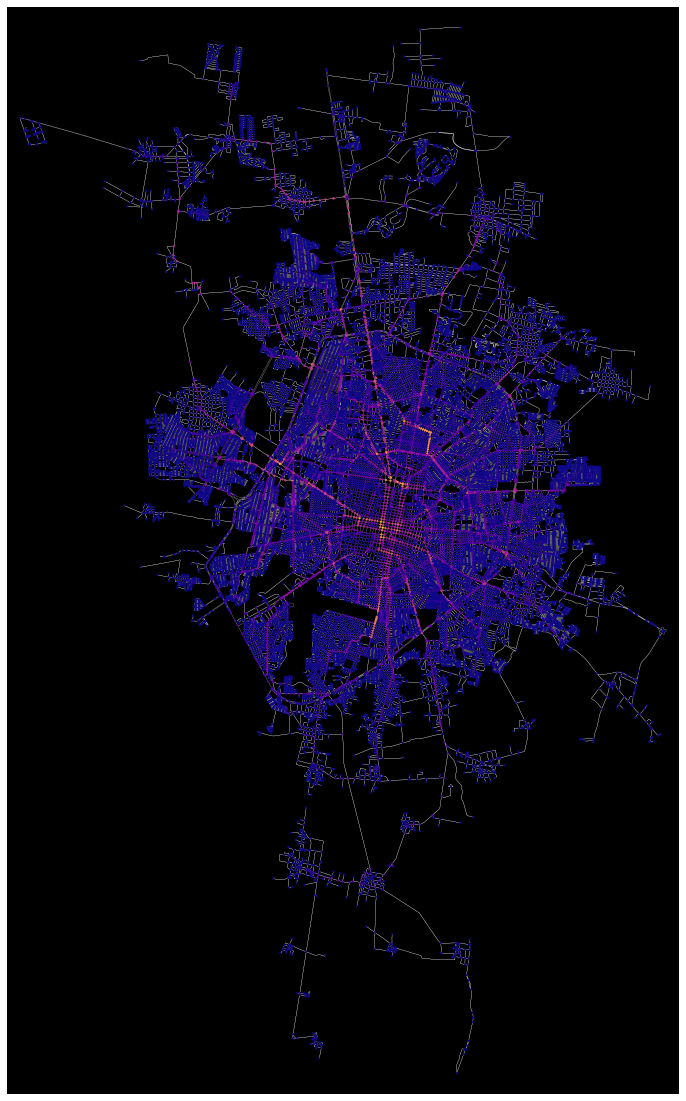

In [50]:
fig, ax = ox.plot_graph(Gs, node_color=nc, node_size=5, node_zorder=2,
                        edge_linewidth=0.2, edge_color='w', bgcolor='k', figsize=(20, 20))

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

## Visualizing Closeness centrality

In [201]:
closeness_scores = ast.literal_eval(stats_city['closeness_centrality'].iloc[0])

In [202]:
max_node, max_cc = max(closeness_scores.items(), key=lambda x: x[1])

In [203]:
max_node, max_cc

(831384158, 0.00011296031630538429)

In [204]:
nc = ['r' if node==max_node else 'w' for node in Gs.nodes()]
ns = [80 if node==max_node else 0 for node in Gs.nodes()]

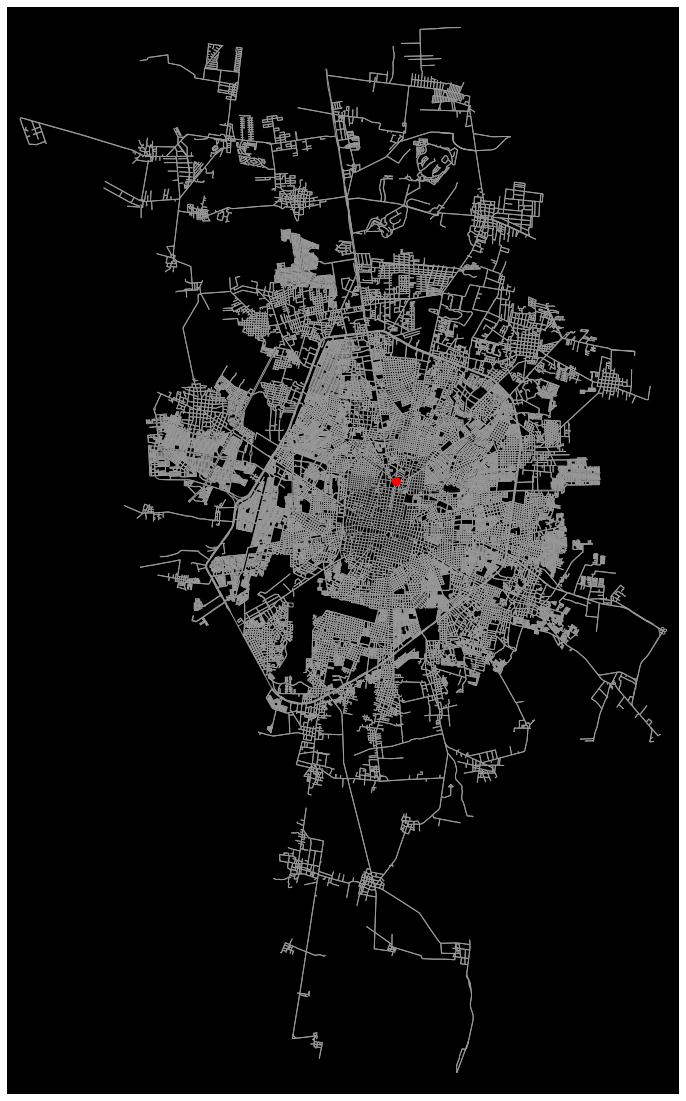

In [173]:
fig, ax = ox.plot_graph(Gs, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20))

A closer look:

In [229]:
# create a network around some (lat, lng) point and plot it
location_point = (20.9774, -89.6169)
G_closer = ox.graph_from_point(location_point, dist=10000, simplify=False, network_type='drive')
G_closer_proj = ox.project_graph(G_closer, to_crs=3857)

In [231]:
nc = ['r' if node==max_node else 'w' for node in G_closer_proj.nodes()]
ns = [80 if node==max_node else 0 for node in G_closer_proj.nodes()]

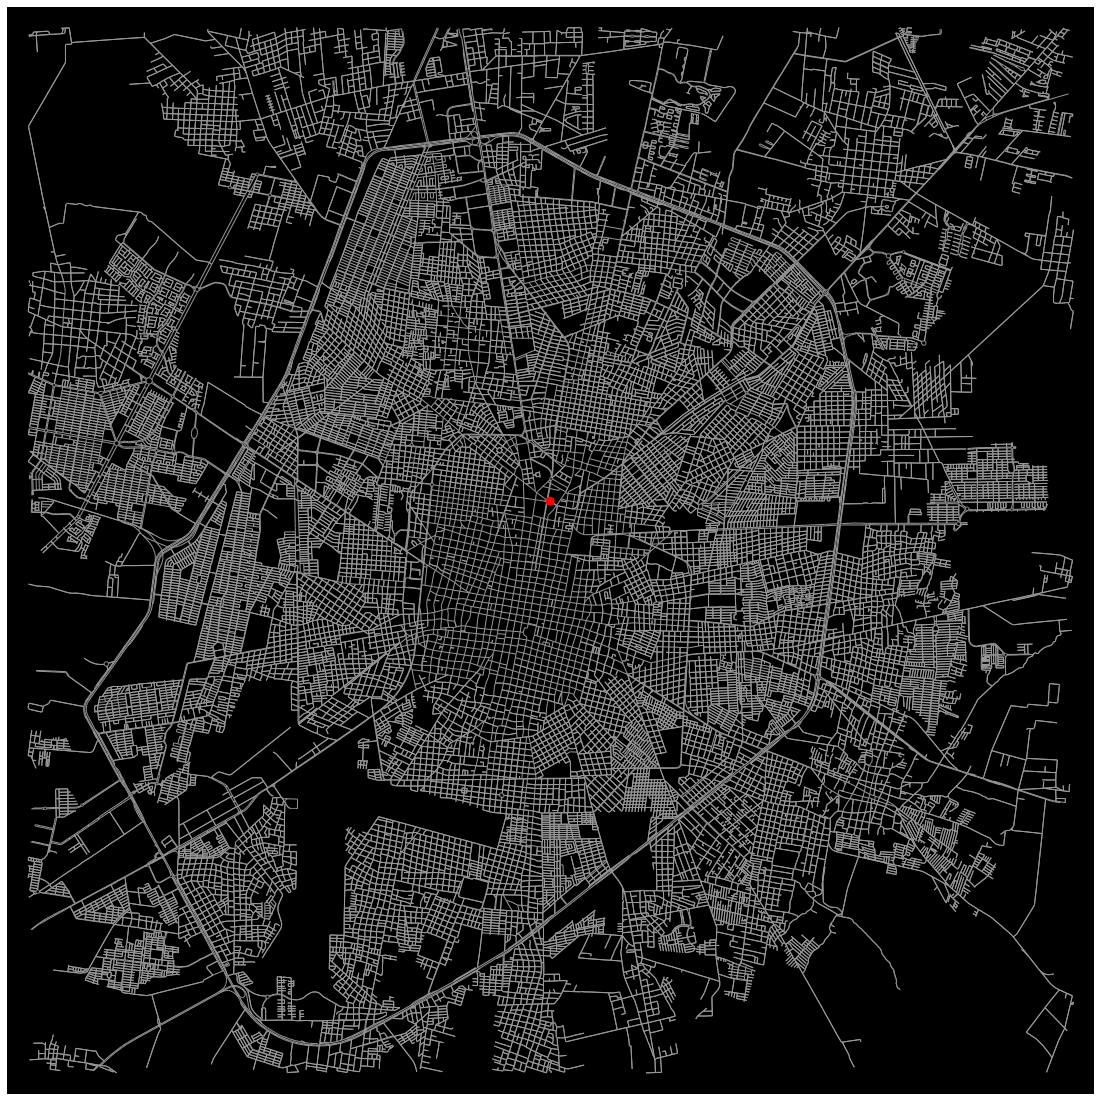

In [232]:
fig, ax = ox.plot_graph(G_closer_proj, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20))

A more closer look: 

In [233]:
# create a network around some (lat, lng) point and plot it
location_point = (20.98476, -89.61411)
G_closerer = ox.graph_from_point(location_point, dist=1000, simplify=False, network_type='drive')
G_closerer_proj = ox.project_graph(G_closerer, to_crs=3857)

In [234]:
nc = ['r' if node==max_node else 'w' for node in G_closerer_proj.nodes()]
ns = [80 if node==max_node else 0 for node in G_closerer_proj.nodes()]

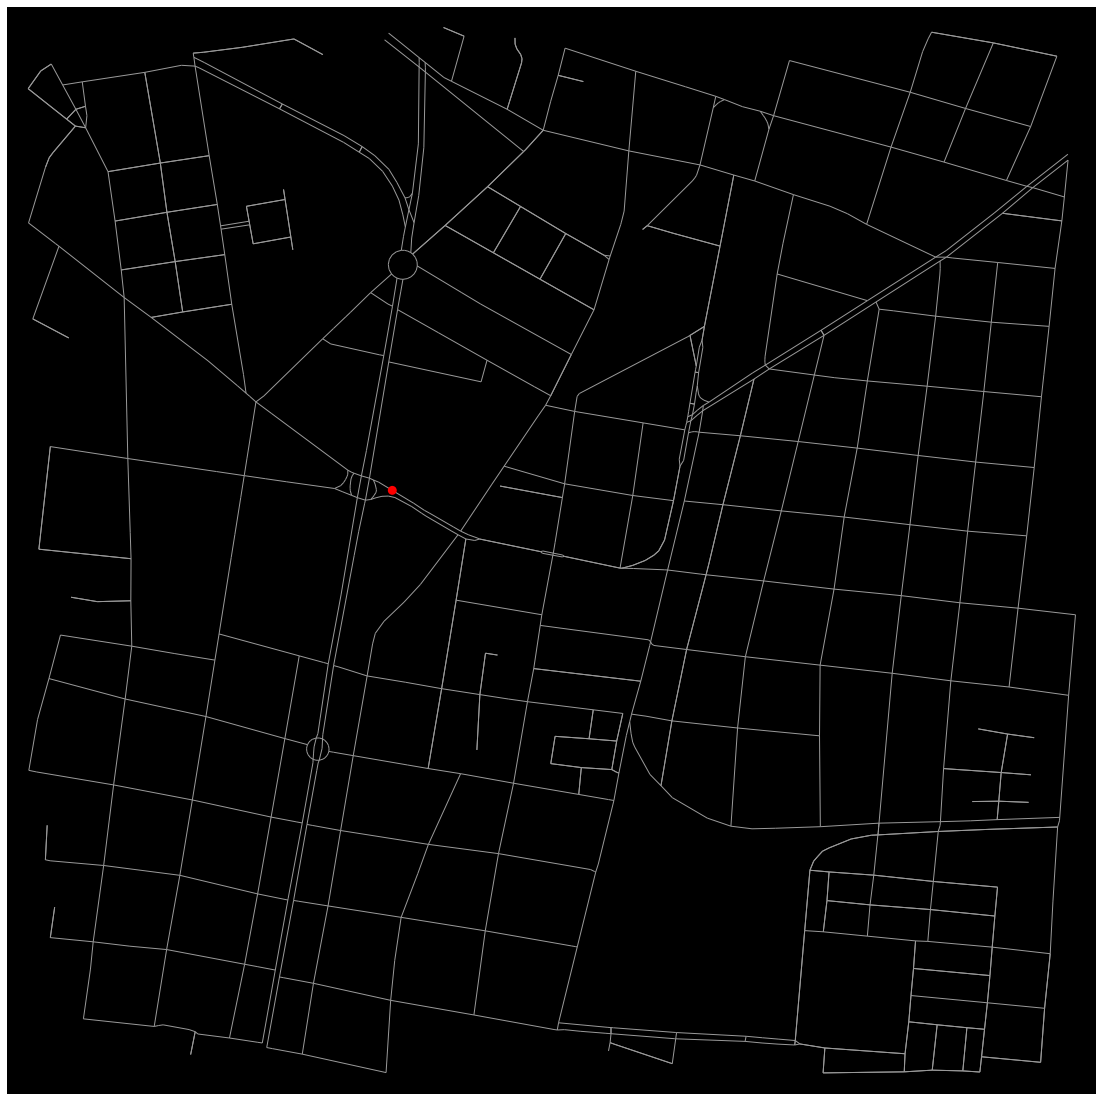

In [235]:
fig, ax = ox.plot_graph(G_closerer_proj, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k', figsize=(20, 20))

In [236]:
nx.set_node_attributes(Gs, closeness_scores, 'cc')
nc = ox.plot.get_node_colors_by_attr(Gs, 'cc', cmap='plasma')

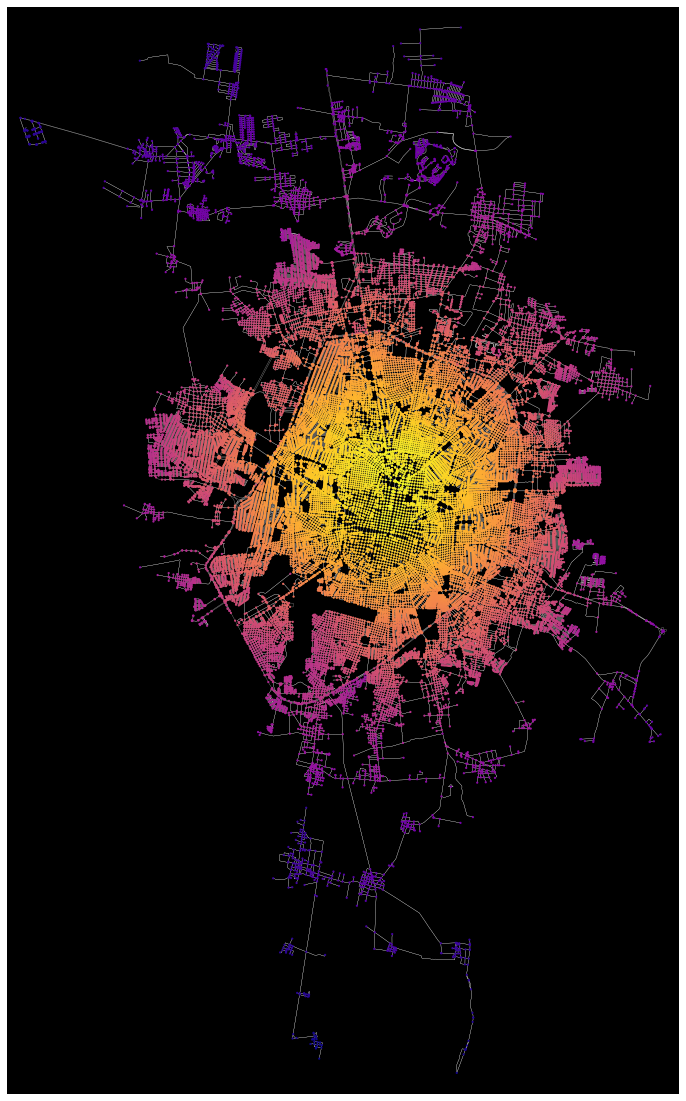

In [237]:
fig, ax = ox.plot_graph(Gs, node_color=nc, node_size=5, node_zorder=2,
                        edge_linewidth=0.2, edge_color='w', bgcolor='k', figsize=(20, 20))